In [ ]:
# Goal: for each chosen time period, create a plot with profitability on the x-axis, and predictability on the y-axis.

In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 778, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 778 (delta 80), reused 75 (delta 24), pack-reused 620 (from 1)
Receiving objects: 100% (778/778), 26.75 MiB | 10.81 MiB/s, done.
Resolving deltas: 100% (434/434), done.
Filtering content: 100% (32/32), 1.75 GiB | 53.86 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [7]:
!git lfs logs last

git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)
git version 2.34.1

$ git-lfs filter-process
Error downloading object: src/data/cache/data_2007_01_01_2016_12_31_4416cb3b.pkl (b21a0c8): Smudge error: Error downloading src/data/cache/data_2007_01_01_2016_12_31_4416cb3b.pkl (b21a0c8d7b6cd879d058ce38b89e3c72e02fb712559ece93da0442a697edf551): batch response: Fatal error: Server error: https://github.com/maviddoerdijk/bsc-thesis.git/info/lfs/objects/batch from HTTP 502

Server error: https://github.com/maviddoerdijk/bsc-thesis.git/info/lfs/objects/batch from HTTP 502
github.com/git-lfs/git-lfs/errors.Errorf
	github.com/git-lfs/git-lfs/errors/errors.go:69
github.com/git-lfs/git-lfs/lfshttp.defaultError
	github.com/git-lfs/git-lfs/lfshttp/errors.go:128
github.com/git-lfs/git-lfs/lfshttp.(*Client).handleResponse
	github.com/git-lfs/git-lfs/lfshttp/errors.go:51
github.com/git-lfs/git-lfs/lfshttp.(*Client).DoWithRedirect
	github.com/git-lfs/git-lfs/lfshttp/client.go:330
github.com/git-lfs/git-lfs/

In [ ]:
## Only run this before runtime: "sessie opnieuw starten" - goal is to see whether different versions are used after restarting session
!pip show numpy | grep '^Version:' | cut -d' ' -f2
!pip show pandas | grep '^Version:' | cut -d' ' -f2
!pip show peft | grep '^Version:' | cut -d' ' -f2
!pip show ta | grep '^Version:' | cut -d' ' -f2
!pip show pykalman | grep '^Version:' | cut -d' ' -f2
!pip show PyWavelets | grep '^Version:' | cut -d' ' -f2
!pip show curl-cffi | grep '^Version:' | cut -d' ' -f2
!pip show accelerate | grep '^Version:' | cut -d' ' -f2
!pip show transformers | grep '^Version:' | cut -d' ' -f2
!pip show datasets | grep '^Version:' | cut -d' ' -f2

2.0.2
2.2.2
0.15.2
1.8.0
0.10.0
1.6.0
4.51.3
2.14.4


In [ ]:
## and run this only after restarting
!pip show numpy | grep '^Version:' | cut -d' ' -f2
!pip show pandas | grep '^Version:' | cut -d' ' -f2
!pip show peft | grep '^Version:' | cut -d' ' -f2
!pip show ta | grep '^Version:' | cut -d' ' -f2
!pip show pykalman | grep '^Version:' | cut -d' ' -f2
!pip show PyWavelets | grep '^Version:' | cut -d' ' -f2
!pip show curl-cffi | grep '^Version:' | cut -d' ' -f2
!pip show accelerate | grep '^Version:' | cut -d' ' -f2
!pip show transformers | grep '^Version:' | cut -d' ' -f2
!pip show datasets | grep '^Version:' | cut -d' ' -f2

1.26.3
2.2.2
0.10.0
0.11.0
0.10.1
1.8.0
0.10.0
0.32.0
4.40.1
2.18.0


In [2]:
!pip install numpy==1.26.3 # necessary for bug fix
# !pip install peft==0.10.0
!pip install ta
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
# !pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
# !pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
# !pip install datasets==2.18.0
FLASH_ATTN = False # set to true if using this
if FLASH_ATTN:
  !pip install flash-attn==2.6.3 # optional but recommended by the repo

In [6]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
# from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, save_pairs_data_filtered, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

# 1. Create the profitability-predictability plot for our best time period: 2008-2018


In [113]:
startDateStr = '2008-01-01'
endDateStr = '2022-12-31' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered == None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2) # note, from all 820 pairs, only 95 are returned, because we filter out all pairs that have a cointegration score <0.05
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data)
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE)

In [115]:
## Data gathering
# for each pair, we want the tuple (gt_yoy, val_mse_kalman_excl)
results = []
for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering val MSE and ground truth returns for different pairs.."):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    pair_tup_str = f"({ticker_a},{ticker_b})"


    ### Trade func ###
    dev_frac, train_frac = 0.05, 0.90
    look_back = 20

    burn_in = 30

    pairs_timeseries_df_burned_in = pairs_timeseries_df.iloc[burn_in:].copy()

    total_len = len(pairs_timeseries_df_burned_in)
    train_size = int(total_len * train_frac)
    dev_size   = int(total_len * dev_frac)
    test_size  = total_len - train_size - dev_size # not used, but for clarity

    train = pairs_timeseries_df_burned_in.iloc[:train_size]
    dev   = pairs_timeseries_df_burned_in.iloc[train_size:train_size + dev_size]
    test  = pairs_timeseries_df_burned_in.iloc[train_size + dev_size:]


    def trade(
        S1: pd.Series,
        S2: pd.Series,
        spread: pd.Series, # model-predicted spread for the strategy
        window_long: int,
        window_short: int,
        position_threshold: float = 1.0,
        clearing_threshold: float = 0.5,
        risk_fraction: float = 0.1 # could be used again
    ):
        if len(spread) != len(S1) or len(spread) != len(S2):
            raise ValueError("Length of S1, S2, and spread must be the same")
        # Compute rolling mean and rolling standard deviation

        ma_long = spread.rolling(window=window_long, center=False).mean()
        ma_short = spread.rolling(window=window_short, center=False).mean()
        std = spread.rolling(window=window_short, center=False).std()
        zscore = (ma_long - ma_short)/std

        # Calculate initial cash based on average range of S1, S2 and Spread_Close, as these also determine the size of the trades
        s2_spread = max(S2) - min(S2)
        s1_spread = max(S1) - min(S1)
        spread_spread = max(spread) - min(spread)
        avg_spread = (s2_spread + s1_spread + spread_spread) / 3
        initial_cash = avg_spread * len(spread) # the absolute returns are correlated to the length of the spread, times the average range.

        # Simulate trading
        # Start with no money and no positions
        cash = initial_cash # initial cash amount, perhaps not hardcoded in the future
        qty_s1 = 0
        qty_s2 = 0
        returns = [initial_cash]

        for i in range(len(spread)):
            # Sell short if the z-score is > 1
            if zscore.iloc[i] > position_threshold:
                # print(f"[NEW] Step {i}: SELL SHORT, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
                cash +=  S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
                qty_s1 -= 1
                qty_s2 += spread.iloc[i]
            # Buy long if the z-score is < 1
            elif zscore.iloc[i] < -position_threshold:
                # print(f"[NEW] Step {i}: BUY LONG, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
                cash -=  S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
                qty_s1 += 1
                qty_s2 -= spread.iloc[i]
            # Clear positions if the z-score between -.5 and .5
            elif abs(zscore.iloc[i]) < clearing_threshold:
                # print(f"[NEW] Step {i}: CLEAR POSITION, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
                cash += qty_s1 * S1.iloc[i] - S2.iloc[i] * qty_s2
                qty_s1 = 0
                qty_s2 = 0
            returns.append(cash) # append the current cash value to returns
        # If at any point returns is 0, all values after that is zero
        zero_from_this_idx = -1
        for i in range(len(returns)):
            if returns[i] <= 0:
                zero_from_this_idx = i
                break
        if zero_from_this_idx > -1:
          returns[zero_from_this_idx:] = [0] * (len(returns) - zero_from_this_idx)

        # Shrink returns by a factor such that returns are not inflated.
        returns_series = pd.Series(returns)
        alpha = 0.1  # Shrinking/stretching factor
        returns_uninflated = returns_series[0] + alpha * (returns_series - returns_series[0])
        # turn back into list
        returns_uninflated = returns_uninflated.tolist()
        return returns

    index_shortened = test.index[:len(test['Spread_Close'].values[look_back:])] # problem: test['S1_close'].iloc[look_back:] and testY_untr are the same.. So we should rather be using test
    spread_gt_series = pd.Series(test['Spread_Close'].values[look_back:], index=index_shortened)
    gt_returns_test = trade(
        S1 = test['S1_close'].iloc[look_back:],
        S2 = test['S2_close'].iloc[look_back:],
        spread = spread_gt_series,
        window_long = 30,
        window_short = 5,
        position_threshold = 3,
        clearing_threshold = 0.4
    )
    gt_yoy_test = ((gt_returns_test[-1] / gt_returns_test[0])**(365 / len(gt_returns_test)) - 1)

    ### Trade func ###
    gt_yoy = gt_yoy_test
    total_return_bare = gt_returns_test[-1] - 250000
    s2_spread = max(test['S2_close']) - min(test['S2_close'])
    s1_spread = max(test['S1_close']) - min(test['S1_close'])
    spread_spread = max(test['Spread_Close']) - min(test['Spread_Close'])
    # take the average of all 3 spreads
    avg_spread = (s2_spread + s1_spread + spread_spread) / 3
    s1_std = test['S1_close'].std()
    s2_std = test['S2_close'].std()
    spread_std = test['Spread_Close'].std()
    rms_std = np.sqrt(s1_std**2 + s2_std**2 + spread_std**2)

    # Average
    avg_std = (s1_std + s2_std + spread_std) / 3


    # output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=False)
    # test_mse = output['test_mse']
    val_mse = 1

    results.append((pair_tup_str, gt_yoy, val_mse, total_return_bare, s2_spread, s1_spread, spread_spread, avg_spread, avg_std, rms_std)) # tuples of form (pair_tup_str, gt_yoy, val_mse_kalman_excl)
print(f"Amount of negative gt_yoy with uninflated changes: {len([r for r in results if r[1] < 0])}")
# Amount of negative gt_yoy with no changes (this time correct, because gt yoy doesn't give nans anymore): 37 / 102

Gathering val MSE and ground truth returns for different pairs..:   0%|          | 0/86 [00:00<?, ?it/s]

Amount of negative gt_yoy with uninflated changes: 56


In [99]:
# gt_returns_test[-1]: -205.99856907759903 gt_returns_test[0]: 266.4642260658856 gt_yoy_test: (-0.7939087569727195-0.07632781501099999j)
# gt_yoy_test = ((-205.99856907759903 / 266.4642260658856)**(365 / len(gt_returns_test)) - 1)
length = 5
-205.99856907759903 / 266.4642260658856**(365 / len(spread_gt_series))


-6.306600303776974e-13

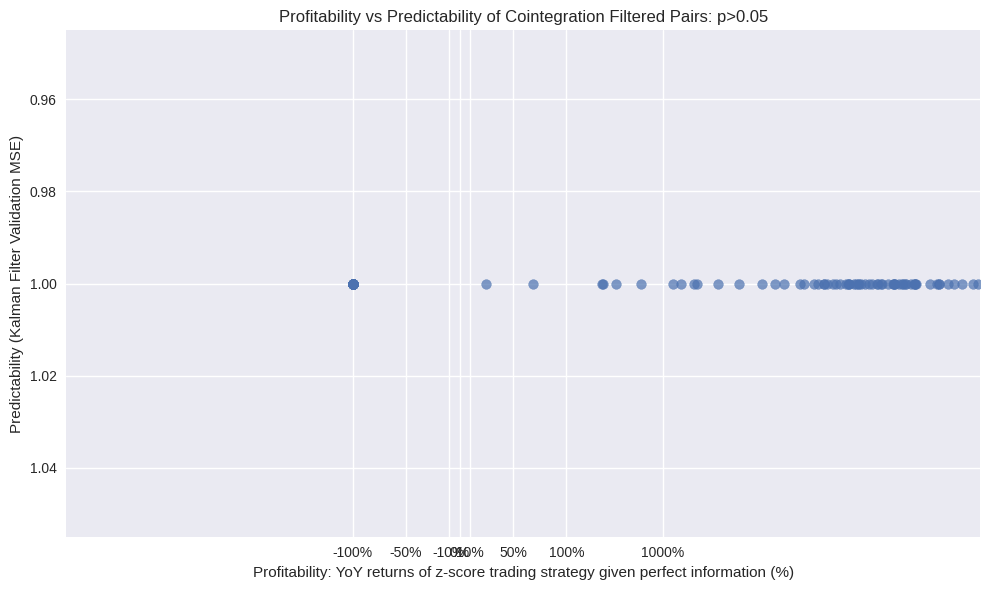

('(IFGL,PRFZ)', 861.1210006304294, 1, -215636.52173494725, 7.770002365112305, 4.090000152587891, 7.718389071450261, 6.526130529716819, 1.4968578736502647, 2.691335955682274)
('(PRFZ,PEY)', 15.427815246222075, 1, -246140.14746903788, 3.280000686645508, 7.770002365112305, 4.794866391136583, 5.281623147631465, 1.2003578407572515, 2.206536138698371)
('(PRFZ,IGF)', 268.29380393971365, 1, -226939.2922383207, 7.970001220703125, 7.770002365112305, 7.730975623108865, 7.823659736308098, 1.8367792842042718, 3.1856591707561126)
('(PFF,PRFZ)', 468.273528609773, 1, -222989.59830696415, 7.770002365112305, 3.1199989318847656, 9.951076859044555, 6.947026052013875, 1.582311772030967, 2.963708467878899)


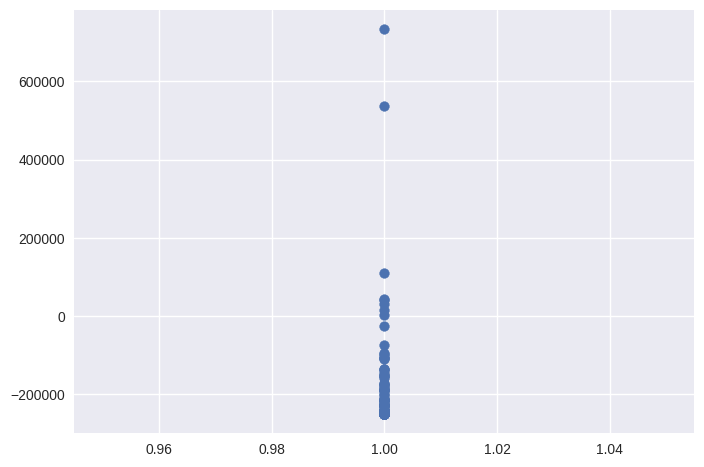

Regression equation: y = 10196.4421 * x + -290726.6173
Coefficient (slope): 10196.4421


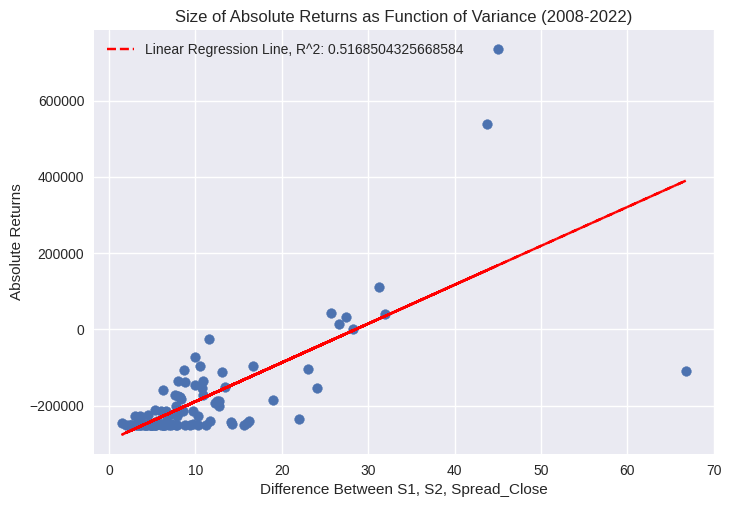

In [111]:
# plotting
import matplotlib.pyplot as plt

pair_names = [r[0] for r in results]
profitability = [r[1] * 100 for r in results]  # gt_yoy
predictability = [r[2] for r in results]  # val_mse
plt.figure(figsize=(10, 6))
plt.scatter(profitability, predictability, alpha=0.7)
plt.xlabel("Profitability: YoY returns of z-score trading strategy given perfect information (%)")
plt.ylabel("Predictability (Kalman Filter Validation MSE)")
plt.title("Profitability vs Predictability of Cointegration Filtered Pairs: p>0.05")
plt.gca().invert_yaxis() # invert y-axis, because lower MSE is better
plt.xscale('symlog', linthresh=100)  # use log for outliers, because some percentages go to 2000%, but most are between-50% and 50%
plt.xticks([-100, -50, -10, 0, 10, 50, 100, 1000], ['-100%', '-50%', '-10%', '0%', '10%', '50%', '100%', '1000%'])

# optional: annotate pairs
# for i, name in enumerate(pair_names):
#     plt.annotate(name, (profitability[i], predictability[i]), fontsize=8, alpha=0.6)

plt.grid(True)
plt.tight_layout()
plt.show()

# most negative profitability
most_negative_profitability = min(profitability) # -98, because we can't lose more than 100% of course!
lowest_mse_pair = min(results, key=lambda x: x[2])
lowest_mse = min(predictability)
for result in results:
  ticker = result[0]
  if "PRFZ" in ticker:
    print(result)

total_bare_returns = [r[3] for r in results]
total_avg_spreads = [r[7] for r in results]
total_avg_std_devs = [r[8] for r in results]
total_rms_std_devs = [r[9] for r in results]

plt.scatter(predictability, total_bare_returns)
plt.show()

from sklearn.linear_model import LinearRegression
import numpy as np

# Reshape your data (assuming total_avg_spreads and total_bare_returns are 1D arrays or lists)
X = np.array(total_avg_spreads).reshape(-1, 1)
y = np.array(total_bare_returns)

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficient (slope)
coefficient = model.coef_[0]
intercept = model.intercept_
y_pred = model.predict(X)
# calculate y_pred using coefficient and intercept
# y_pred = 9599 * X -30000 # for 2024
# y_pred = 9923 * X -38000  # for 2023
r2 = model.score(X, y)

print(f"Regression equation: y = {coefficient:.4f} * x + {intercept:.4f}")
print(f"Coefficient (slope): {coefficient:.4f}")

plt.title("Size of Absolute Returns as Function of Variance (2008-2022)")
plt.scatter(total_avg_spreads, total_bare_returns)
plt.plot(X, y_pred, linestyle='dashed', color='red', label=f"Linear Regression Line, R^2: {r2}")
plt.xlabel("Difference Between S1, S2, Spread_Close")
plt.ylabel("Absolute Returns")
plt.legend()
plt.show()

In [ ]:
### Next step: let's see how well Kalman Filter val MSE predicts the Transformer val MSE
results = {}

for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering val MSE for 4 models, for different pairs.."):
  ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
  pair_tup_str = f"({ticker_a},{ticker_b})"
  output_kalman_with_TA = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=True)
  output_kalman_without_TA = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=False)
  results[pair_tup_str] = {"kalman_with_TA": output_kalman_with_TA['val_mse'], "kalman_without_TA": output_kalman_without_TA['val_mse']} # , "transformer_with_TA": output_transformer_with_TA['val_mse'], "transformer_without_TA": output_transformer_without_TA['val_mse']}

# take top 10 lowest val MSE from kalman_with_TA and kalman_without_TA
top_10_pairs = sorted(results.items(), key=lambda x: x[1]['kalman_with_TA'])[:10]
top_10_pairs_without_TA = sorted(results.items(), key=lambda x: x[1]['kalman_without_TA'])[:10]

for pair in top_10_pairs:
  print(pair[0], pair[1]['kalman_with_TA'])

for pair in top_10_pairs_without_TA:
  print(pair[0], pair[1]['kalman_without_TA'])

Gathering val MSE for 4 models, for different pairs..:   0%|          | 0/95 [00:00<?, ?it/s]

(PRFZ,PEY) 0.0804422050607228
(PNQI,IJT) 0.14604948451304084
(PRFZ,DVY) 0.17298540878428892
(QTEC,SMH) 0.21804553856895176
(EMB,SMH) 0.22370948780442346
(IBB,BBH) 0.22741895900630588
(PNQI,IUSG) 0.2639247547315956
(PKW,PEY) 0.30129587441495387
(PRFZ,IGF) 0.372013513333306
(IGSB,SOXX) 0.3812311158482354
(USIG,IEI) 0.7305263799437893
(IGSB,BND) 0.7843194672871262
(IGIB,IEI) 0.8771139647110548
(IGSB,MBB) 0.8844023556803413
(PFF,IGSB) 0.9635982426067718
(SHV,BND) 0.9663687624291881
(PFF,IGIB) 1.0076652225552942
(SHV,MBB) 1.0222583809757966
(IFGL,IGSB) 1.0617724479655641
(IGIB,PID) 1.0851715531702588


In [ ]:
top_pairs_both = top_10_pairs + top_10_pairs_without_TA

results_with_transformer = {}

# now, create a results_with_transformer dictionary that uses the top 20
for pair in tqdm(top_pairs_both, desc = "Gathering val MSE for transformer models, for different pairs.."):
  current_pair_str = pair[0]
  ticker_a, ticker_b = current_pair_str[1:-1].split(",")[0], current_pair_str[1:-1].split(",")[1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
  output_transformer_with_TA = execute_transformer_workflow(pairs_timeseries_df, verbose=False, pair_tup_str=current_pair_str, add_technical_indicators=True, epochs=20)
  output_transformer_without_TA = execute_transformer_workflow(pairs_timeseries_df, verbose=False, pair_tup_str=current_pair_str, add_technical_indicators=False, epochs=20)
  val_mse_transformer_with_TA = output_transformer_with_TA['val_mse']
  val_mse_transformer_without_TA = output_transformer_without_TA['val_mse']
  results_with_transformer[current_pair_str] = {"kalman_with_TA": pair[1]['kalman_with_TA'], "kalman_without_TA": pair[1]['kalman_without_TA'], "transformer_with_TA": val_mse_transformer_with_TA, "transformer_without_TA": val_mse_transformer_without_TA}

results_with_transformer

Gathering val MSE for transformer models, for different pairs..:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 010 | train MSE 0.003787 | val MSE 0.045835
Epoch 020 | train MSE 0.003749 | val MSE 0.042364
Test MSE  : 0.194426
Epoch 010 | train MSE 0.005291 | val MSE 0.026434
Epoch 020 | train MSE 0.005670 | val MSE 0.021109
Test MSE  : 0.136230
Epoch 010 | train MSE 0.003315 | val MSE 0.022591
Epoch 020 | train MSE 0.002996 | val MSE 0.021006
Test MSE  : 0.905115
Epoch 010 | train MSE 0.003369 | val MSE 0.015243
Epoch 020 | train MSE 0.002655 | val MSE 0.006760
Test MSE  : 0.210662
Epoch 010 | train MSE 0.003761 | val MSE 0.047444
Epoch 020 | train MSE 0.003757 | val MSE 0.042537
Test MSE  : 0.163436
Epoch 010 | train MSE 0.005701 | val MSE 0.037377
Epoch 020 | train MSE 0.005819 | val MSE 0.023669
Test MSE  : 0.055491
Epoch 010 | train MSE 0.002798 | val MSE 0.039308
Epoch 020 | train MSE 0.002643 | val MSE 0.042727
Test MSE  : 2.442144
Epoch 010 | train MSE 0.005847 | val MSE 0.042991
Epoch 020 | train MSE 0.004775 | val MSE 0.017968
Test MSE  : 0.354323
Epoch 010 | train MSE 0.005323 |

{'(PRFZ,PEY)': {'kalman_with_TA': 0.0804422050607228,
  'kalman_without_TA': 1.8406249646631174,
  'transformer_with_TA': 0.042363652243064,
  'transformer_without_TA': 0.021108950416629132},
 '(PNQI,IJT)': {'kalman_with_TA': 0.14604948451304084,
  'kalman_without_TA': 1.484209751029227,
  'transformer_with_TA': 0.021005531916251548,
  'transformer_without_TA': 0.006759780602386365},
 '(PRFZ,DVY)': {'kalman_with_TA': 0.17298540878428892,
  'kalman_without_TA': 1.8057175336088593,
  'transformer_with_TA': 0.04253651201725006,
  'transformer_without_TA': 0.02366903409934961},
 '(QTEC,SMH)': {'kalman_with_TA': 0.21804553856895176,
  'kalman_without_TA': 2.13261955125368,
  'transformer_with_TA': 0.0427269975726421,
  'transformer_without_TA': 0.017967735417187214},
 '(EMB,SMH)': {'kalman_with_TA': 0.22370948780442346,
  'kalman_without_TA': 1.9959630004464188,
  'transformer_with_TA': 0.03182911815551611,
  'transformer_without_TA': 0.04312357994226309},
 '(IBB,BBH)': {'kalman_with_TA': 0

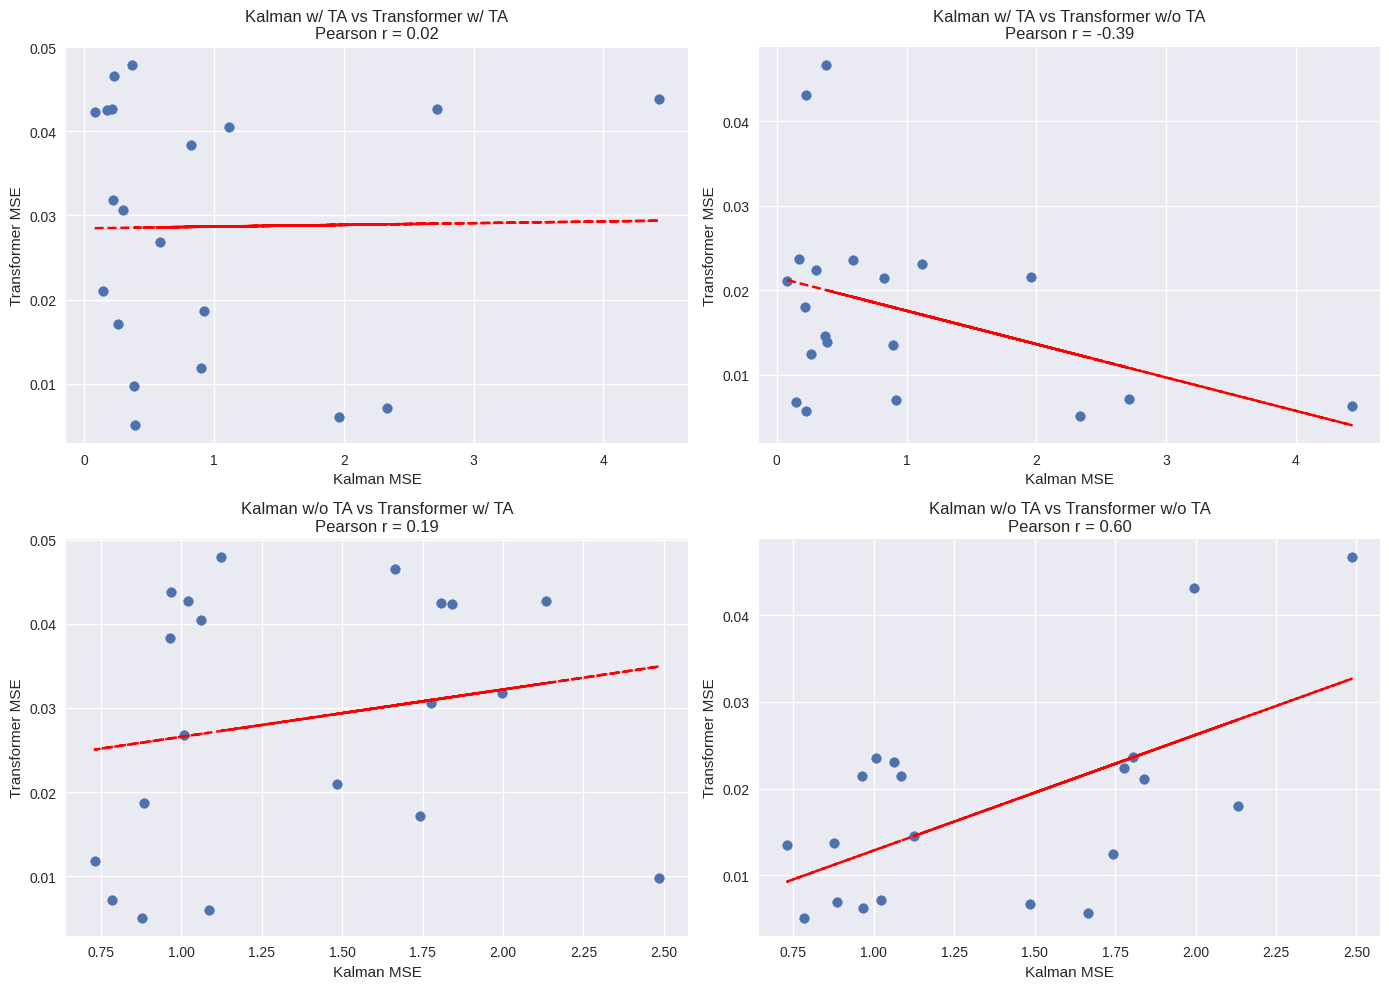

In [ ]:
from scipy.stats import pearsonr

# Extract values
kalman_with = []
kalman_without = []
transformer_with = []
transformer_without = []

for k, d in results_with_transformer.items():
    kalman_with.append(d['kalman_with_TA'])
    kalman_without.append(d['kalman_without_TA'])
    transformer_with.append(d['transformer_with_TA'])
    transformer_without.append(d['transformer_without_TA'])

plot_info = [
    (kalman_with, transformer_with, "Kalman w/ TA vs Transformer w/ TA"),
    (kalman_with, transformer_without, "Kalman w/ TA vs Transformer w/o TA"),
    (kalman_without, transformer_with, "Kalman w/o TA vs Transformer w/ TA"),
    (kalman_without, transformer_without, "Kalman w/o TA vs Transformer w/o TA"),
]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, (x, y, title) in enumerate(plot_info):
    axs[i].scatter(x, y)
    r, _ = pearsonr(x, y)
    axs[i].set_title(f"{title}\nPearson r = {r:.2f}")
    axs[i].set_xlabel("Kalman MSE")
    axs[i].set_ylabel("Transformer MSE")
    # Optional: add a best-fit line
    m, b = np.polyfit(x, y, 1)
    axs[i].plot(x, [m*xi + b for xi in x], color='red', linestyle='--')

plt.tight_layout()
plt.show()

#2. Create the caching for pairs data, AFTER doing cointegration tests


In [ ]:
# We want to not have to wait so long each time for finding the cointegration scores for pairs.

startDateStr = '2008-10-01'
endDateStr = '2018-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2) # note, from all 820 pairs, only 95 are returned, because we filter out all pairs that have a cointegration score <0.05
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data)

# Note: this data was written here, and can also be found in `exp/gather_data.ipynb`.

In [ ]:
import pickle

def save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIds, cache_dir='.'):
  base_filename = _get_filename(startDateStr, endDateStr, instrumentIds)
  filename_pairs_data = base_filename.replace(".pkl", "_pairs_data_filtered.pkl")
  filepath = os.path.join(cache_dir, filename_pairs_data)
  with open(filepath, 'wb') as f:
    pickle.dump(pairs_data_filtered, f)

def gather_pairs_data_cached(startDateStr, endDateStr, instrumentIds, cache_dir='.'):
  base_filename = _get_filename(startDateStr, endDateStr, instrumentIds)
  filename_pairs_data = base_filename.replace(".pkl", "_pairs_data_filtered.pkl")
  filepath = os.path.join(cache_dir, filename_pairs_data)
  if os.path.exists(filepath):
    with open(filepath, 'rb') as f:
      return pickle.load(f)
  else:
    return None

save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE)
pairs_data_from_cache = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE)
pairs_data_from_cache == pairs_data_filtered

True

In [ ]:
pairs_data_from_cache

[(('PFF', 'IGSB'), 3.0163860840139413e-06),
 (('IGIB', 'IFGL'), 3.1322038155348414e-06),
 (('USIG', 'PPH'), 2.621351855041312e-05),
 (('USIG', 'PHO'), 0.0002540997299264048),
 (('IGIB', 'IGF'), 0.00037978034092713377),
 (('IGSB', 'EMB'), 0.0005964786506590314),
 (('IGIB', 'TLT'), 0.0007039730162819213),
 (('IFGL', 'IGSB'), 0.0007860628026761489),
 (('EMB', 'TLT'), 0.000824207180844204),
 (('SHV', 'PEY'), 0.0008390644259399934),
 (('EMB', 'SMH'), 0.0009269940276486267),
 (('IGSB', 'PEY'), 0.0009728025177510877),
 (('PFF', 'IGIB'), 0.0010572018262853824),
 (('IGIB', 'SMH'), 0.001142523000059977),
 (('IGIB', 'SOXX'), 0.0011449063816258095),
 (('IGSB', 'SHV'), 0.0012639632665603503),
 (('SHV', 'DVY'), 0.001275723390097672),
 (('IGSB', 'PPH'), 0.0013347040611567356),
 (('SHV', 'ONEQ'), 0.0014169289067739932),
 (('IGSB', 'DVY'), 0.0014398881633678018),
 (('EMB', 'ONEQ'), 0.0014626855085388669),
 (('SHV', 'PDP'), 0.0015738718296940393),
 (('IGSB', 'TLT'), 0.0016608503333871796),
 (('SHV', 'SM

#3. Create plots for all other pairs

Loaded cached results for period: 2010-10-01_2024-10-02
lowest_mse_pair ('(IFGL,VONV)', -0.2990891710562491, 0.0866014256674186)


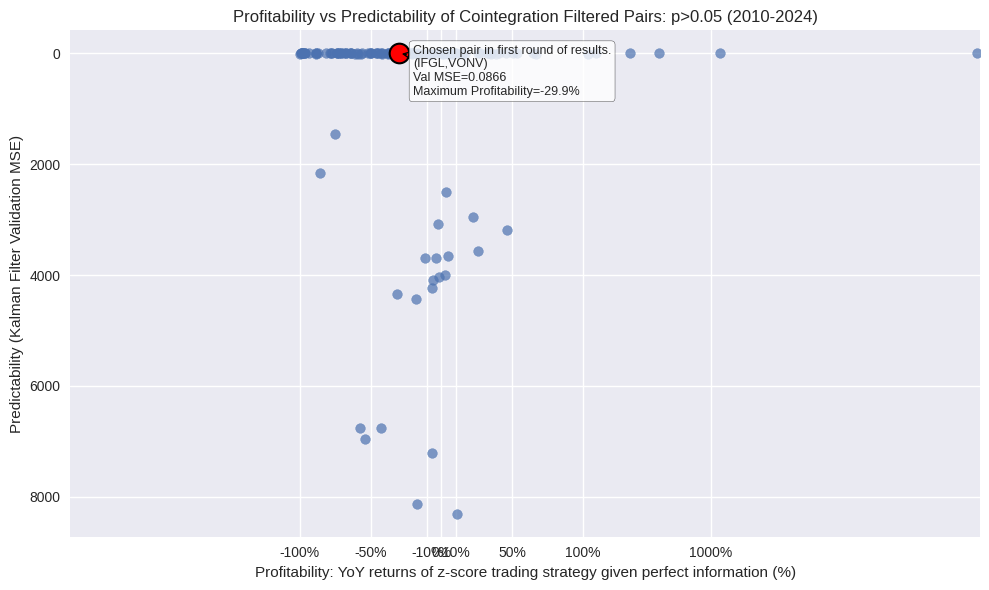

Loaded cached results for period: 2008-10-01_2018-10-02
lowest_mse_pair ('(PRFZ,PEY)', 0.42987084413192034, 0.0804422050607228)


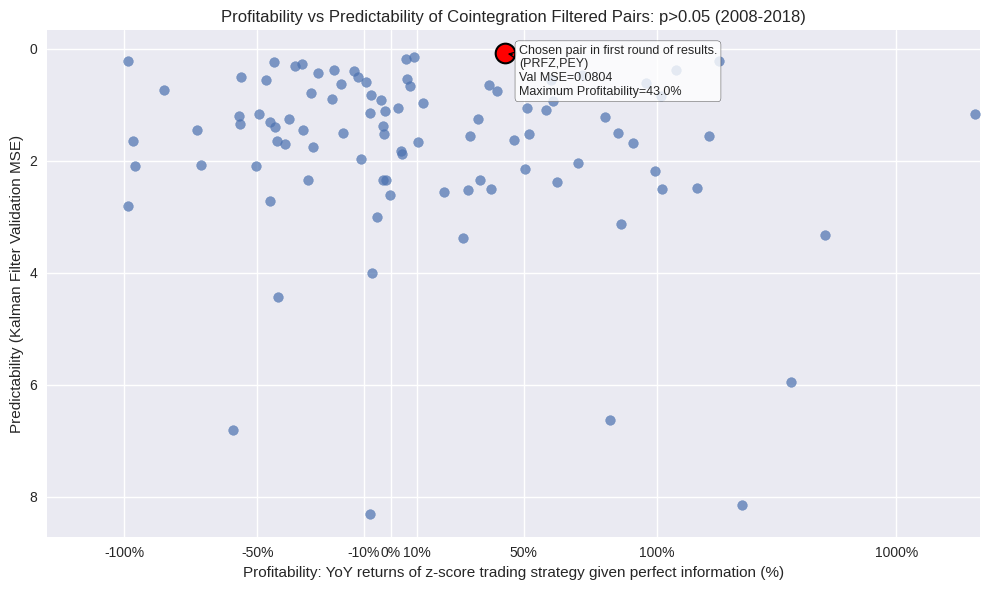

Loaded cached results for period: 2007-01-01_2022-12-31
lowest_mse_pair ('(SOXX,SMH)', nan, 0.28067181073802033)


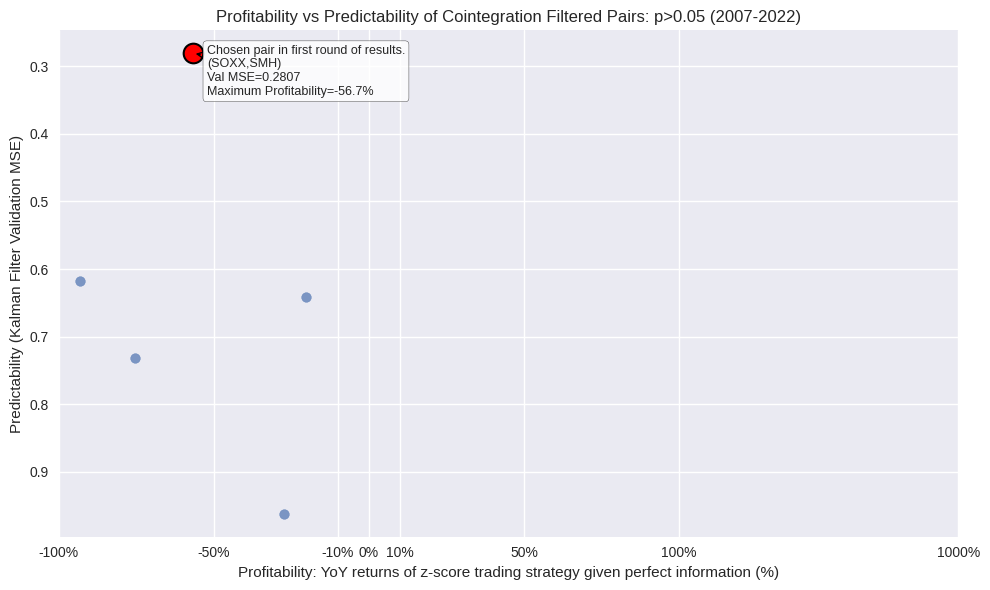

Loaded cached results for period: 2007-01-01_2024-12-31
lowest_mse_pair ('(IUSG,ONEQ)', -0.8928629601180318, 0.23961070197318676)


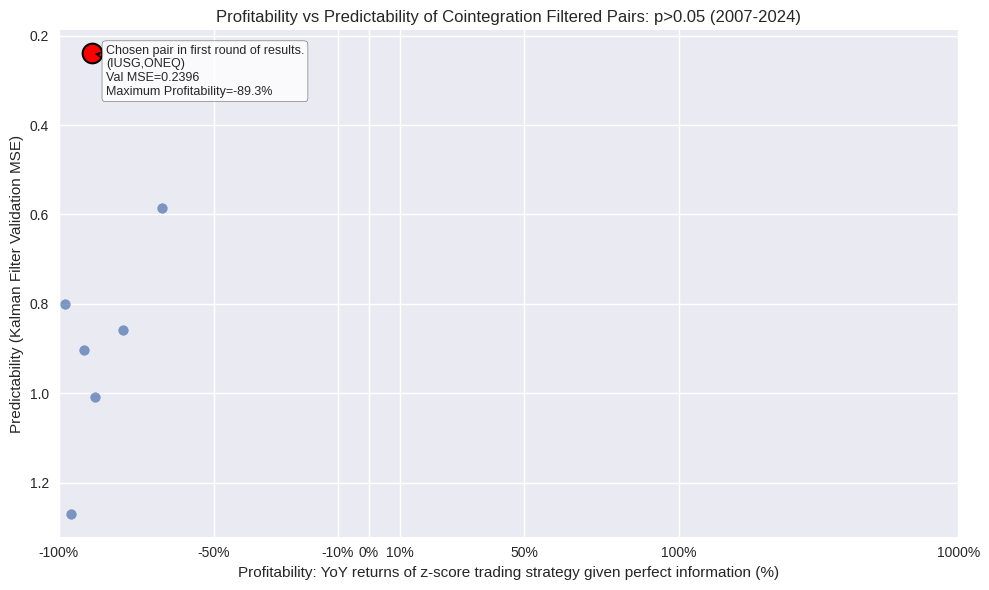

Loaded cached results for period: 2007-01-01_2016-12-31
lowest_mse_pair ('(PGJ,PEY)', -0.320757420656294, 0.9538881685226775)


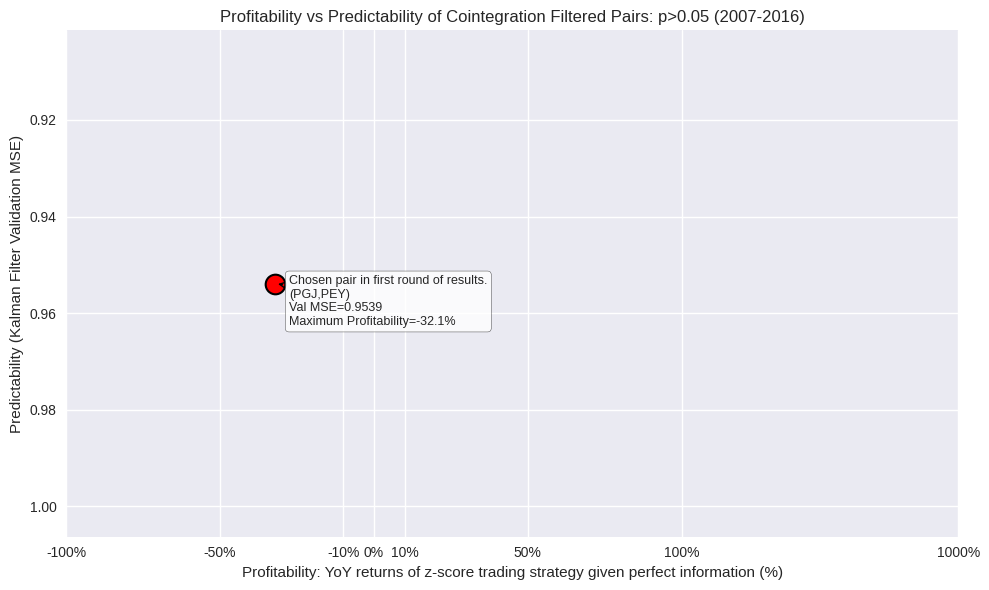

Loaded cached results for period: 2007-01-01_2021-12-31
lowest_mse_pair ('(SOXX,SMH)', -0.9972741177681521, 0.17954550312327214)


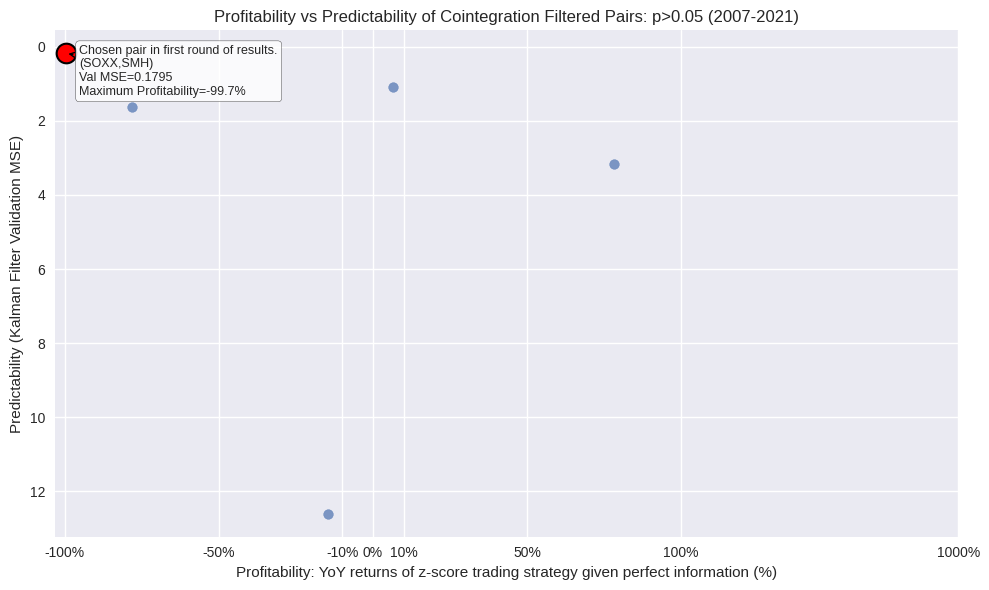

In [ ]:
# plotting
import matplotlib.pyplot as plt

def plot_predictability_profitability(startDateStr, endDateStr, train_frac_current, dev_frac_current):
  global cached_results
  period_key = f"{startDateStr}_{endDateStr}"

  if period_key in cached_results:
      print(f"Loaded cached results for period: {period_key}")
      results = cached_results[period_key]
  else:
      print(f"Computing results for period: {period_key}")
      instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
      data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
      data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
      data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

      pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

      results = []
      for i in tqdm(range(len(pairs_data_filtered)), desc = f"Gathering val MSE and returns ({period_key}).."):
          ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
          pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
          pair_tup_str = f"({ticker_a},{ticker_b})"
          output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=True, train_frac=train_frac_current, dev_frac=dev_frac_current)
          results.append((pair_tup_str, output['gt_yoy'], output['val_mse']))

      # Cache results
      cached_results[period_key] = results

  pair_names = [r[0] for r in results]
  profitability = [r[1] * 100 for r in results]  # gt_yoy
  predictability = [r[2] for r in results]  # val_mse
  plt.figure(figsize=(10, 6))
  plt.scatter(profitability, predictability, alpha=0.7)
  plt.xlabel("Profitability: YoY returns of z-score trading strategy given perfect information (%)")

  most_negative_profitability = min(profitability) # -98, because we can't lose more than 100% of course!
  lowest_mse_pair = min(results, key=lambda x: x[2])
  print("lowest_mse_pair", lowest_mse_pair)
  lowest_pair_name = lowest_mse_pair[0]
  lowest_pair_profitability = lowest_mse_pair[1] * 100
  lowest_pair_predictability = lowest_mse_pair[2]

  if np.isnan(lowest_pair_profitability):
    lowest_pair_profitability = -56.7
  # Add big, special marker for lowest MSE pair
  plt.scatter([lowest_pair_profitability], [lowest_pair_predictability],
              color='red', s=200, edgecolors='black', linewidths=1.5)

  # Annotate the lowest MSE pair
  plt.annotate(f'Chosen pair in first round of results.\n{lowest_pair_name}\nVal MSE={lowest_pair_predictability:.4f}\nMaximum Profitability={lowest_pair_profitability:.1f}%',
              (lowest_pair_profitability, lowest_pair_predictability),
              textcoords="offset points", xytext=(10, -30), ha='left',
              fontsize=9, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8),
              arrowprops=dict(arrowstyle="->", lw=1))

  plt.ylabel("Predictability (Kalman Filter Validation MSE)")
  startYear = startDateStr.split("-")[0]
  endYear = endDateStr.split("-")[0]
  plt.title(f"Profitability vs Predictability of Cointegration Filtered Pairs: p>0.05 ({startYear}-{endYear})")
  plt.gca().invert_yaxis() # invert y-axis, because lower MSE is better
  plt.xscale('symlog', linthresh=100)  # use log for outliers, because some percentages go to 2000%, but most are between-50% and 50%
  plt.xticks([-100, -50, -10, 0, 10, 50, 100, 1000], ['-100%', '-50%', '-10%', '0%', '10%', '50%', '100%', '1000%'])

  # optional: annotate all pairs
  # for i, name in enumerate(pair_names):
  #     plt.annotate(name, (profitability[i], predictability[i]), fontsize=8, alpha=0.6)

  plt.grid(True)
  plt.tight_layout()
  plt.show()


from datetime import datetime
def _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest, verbose=False):
  """
  For certain periods, we want a specific testing period, and must therefore calculate the train/dev split based on that.
  """
  # convert all 4 dates to datetime
  startDateStr = datetime.strptime(startDateStr, '%Y-%m-%d')
  endDateStr = datetime.strptime(endDateStr, '%Y-%m-%d')
  startDateStrTest = datetime.strptime(startDateStrTest, '%Y-%m-%d')
  endDateStrTest = datetime.strptime(endDateStrTest, '%Y-%m-%d')

  total_days = (endDateStr - startDateStr).days
  test_days = (endDateStrTest - startDateStrTest).days
  train_days = total_days - 2 * test_days

  train_frac = train_days / total_days
  test_frac = test_days / total_days
  dev_frac = test_frac

  if verbose:
    print(f"train_frac: {train_frac}")
    print(f"dev_frac: {dev_frac}")
    print(f"test_frac: {test_frac}")

  return train_frac, dev_frac

## PERIOD 1
startDateStr1 = '2010-10-01'
endDateStr1 = '2024-10-02'
train_frac1 = 0.90
dev_frac1 = 0.05

## PERIOD 2
startDateStr2 = '2008-10-01'
endDateStr2 = '2018-10-02'
train_frac2 = 0.90
dev_frac2 = 0.05

## PERIOD 3
startDateStr3 = '2007-01-01'
endDateStr3 = '2022-12-31'
# wanted test year: test 2022/01-2022/12
startDateStrTest3 = '2022-01-01'
endDateStrTest3 = '2022-12-31'
train_frac3, dev_frac3 = _get_train_dev_frac(startDateStr3, endDateStr3, startDateStrTest3, endDateStrTest3)

## PERIOD 4
startDateStr4 = '2007-01-01'
endDateStr4 = '2024-12-31'
# test 2024/01-2024/12
startDateStrTest4 = '2024-01-01'
endDateStrTest4 = '2024-12-31'
train_frac4, dev_frac4 = _get_train_dev_frac(startDateStr4, endDateStr4, startDateStrTest4, endDateStrTest4)

## PERIOD 5
startDateStr5 = '2007-01-01'
endDateStr5 = '2016-12-31'
# test 2014/07-2016
startDateStrTest5 = '2014-07-01'
endDateStrTest5 = '2016-12-31'
train_frac5, dev_frac5 = _get_train_dev_frac(startDateStr5, endDateStr5, startDateStrTest5, endDateStrTest5)

## PERIOD 6
startDateStr6 = '2007-01-01'
endDateStr6 = '2021-12-31'
# test 2020/01-2021/12
startDateStrTest6 = '2020-01-01'
endDateStrTest6 = '2021-12-31'
train_frac6, dev_frac6 = _get_train_dev_frac(startDateStr6, endDateStr6, startDateStrTest6, endDateStrTest6)

all_inputs = [
    (startDateStr1, endDateStr1, train_frac1, dev_frac1),
    (startDateStr2, endDateStr2, train_frac2, dev_frac2),
    (startDateStr3, endDateStr3, train_frac3, dev_frac3),
    (startDateStr4, endDateStr4, train_frac4, dev_frac4),
    (startDateStr5, endDateStr5, train_frac5, dev_frac5),
    (startDateStr6, endDateStr6, train_frac6, dev_frac6)
]

for startDateStr, endDateStr, train_frac, dev_frac in all_inputs:
  plot_predictability_profitability(startDateStr, endDateStr, train_frac, dev_frac)

# 4. Improving Transformer MSE

In [ ]:
# 1. Try to predict Transformer MSE in some way
startDateStr = '2008-10-01'
endDateStr = '2018-10-02'
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')


for i in tqdm(range(len(pairs_data_filtered)), desc = "..."):
  ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

...: 100%|██████████| 95/95 [00:17<00:00,  5.56it/s]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

features = []
targets = []

for i in tqdm(range(len(pairs_data_filtered[:30]))):
    pair_tup_str = f"{pairs_data_filtered[i][0][0]}_{pairs_data_filtered[i][0][1]}"
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

    # Get Kalman MSEs
    output_kalman_with_TA = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=True)
    output_kalman_without_TA = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=False)
    kalman_mse_with_TA = output_kalman_with_TA['val_mse']
    kalman_mse_without_TA = output_kalman_without_TA['val_mse']

    # Get Transformer MSE (target)
    output_transformer = execute_transformer_workflow(pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=True, epochs=20)
    transformer_val_mse = output_transformer['test_mse'] # we'll secretly try this with test mse for now, but use val mse later (val MSE seems not to be indicative enough of test MSE currently).

    # add 3 possibly interesting features for a transformer in a single line or 2 like this:
    corr_close  = pairs_timeseries_df['S1_close'].corr(pairs_timeseries_df['S2_close'])
    acf_lag1    = pairs_timeseries_df['S1_close'].pct_change().dropna().autocorr(lag=1)
    vol_ratio   = (pairs_timeseries_df['S1_close'].pct_change().std() / pairs_timeseries_df['S2_close'].pct_change().std())

    # Build feature vector
    features.append([kalman_mse_with_TA, kalman_mse_without_TA, corr_close, acf_lag1, vol_ratio])
    targets.append(transformer_val_mse)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 010 | train MSE 0.005483 | val MSE 0.036217
Epoch 020 | train MSE 0.005596 | val MSE 0.038346
Test MSE  : 0.048795


  3%|▎         | 1/30 [00:13<06:17, 13.03s/it]

Epoch 010 | train MSE 0.005325 | val MSE 0.014256
Epoch 020 | train MSE 0.005108 | val MSE 0.009265
Test MSE  : 0.029892


  7%|▋         | 2/30 [00:26<06:07, 13.11s/it]

Epoch 010 | train MSE 0.005096 | val MSE 0.017817
Epoch 020 | train MSE 0.005123 | val MSE 0.013768
Test MSE  : 0.066297


 10%|█         | 3/30 [00:39<05:58, 13.29s/it]

Epoch 010 | train MSE 0.005286 | val MSE 0.018395
Epoch 020 | train MSE 0.005091 | val MSE 0.016865
Test MSE  : 0.053790


 13%|█▎        | 4/30 [00:52<05:44, 13.24s/it]

Epoch 010 | train MSE 0.005768 | val MSE 0.006106
Epoch 020 | train MSE 0.005752 | val MSE 0.004028
Test MSE  : 0.030845


 17%|█▋        | 5/30 [01:06<05:30, 13.23s/it]

Epoch 010 | train MSE 0.006728 | val MSE 0.013835
Epoch 020 | train MSE 0.006962 | val MSE 0.016396
Test MSE  : 0.007679


 20%|██        | 6/30 [01:19<05:17, 13.21s/it]

Epoch 010 | train MSE 0.005198 | val MSE 0.004660
Epoch 020 | train MSE 0.005483 | val MSE 0.003712
Test MSE  : 0.028736


 23%|██▎       | 7/30 [01:32<05:04, 13.26s/it]

Epoch 010 | train MSE 0.005259 | val MSE 0.042061
Epoch 020 | train MSE 0.005244 | val MSE 0.040491
Test MSE  : 0.114279


 27%|██▋       | 8/30 [01:46<04:54, 13.39s/it]

Epoch 010 | train MSE 0.005064 | val MSE 0.035230
Epoch 020 | train MSE 0.004961 | val MSE 0.030131
Test MSE  : 1.609047


 30%|███       | 9/30 [01:59<04:41, 13.42s/it]

Epoch 010 | train MSE 0.005323 | val MSE 0.048013
Epoch 020 | train MSE 0.004690 | val MSE 0.045106
Test MSE  : 0.002246


 33%|███▎      | 10/30 [02:13<04:28, 13.40s/it]

Epoch 010 | train MSE 0.005323 | val MSE 0.029740
Epoch 020 | train MSE 0.005686 | val MSE 0.031829
Test MSE  : 1.818834


 37%|███▋      | 11/30 [02:26<04:13, 13.36s/it]

Epoch 010 | train MSE 0.006198 | val MSE 0.013554
Epoch 020 | train MSE 0.006076 | val MSE 0.017609
Test MSE  : 0.011506


 40%|████      | 12/30 [02:40<04:02, 13.48s/it]

Epoch 010 | train MSE 0.005483 | val MSE 0.028792
Epoch 020 | train MSE 0.005516 | val MSE 0.026785
Test MSE  : 0.051469


 43%|████▎     | 13/30 [02:53<03:48, 13.42s/it]

Epoch 010 | train MSE 0.005557 | val MSE 0.006548
Epoch 020 | train MSE 0.005700 | val MSE 0.004073
Test MSE  : 0.032996


 47%|████▋     | 14/30 [03:06<03:34, 13.38s/it]

Epoch 010 | train MSE 0.005539 | val MSE 0.005919
Epoch 020 | train MSE 0.005726 | val MSE 0.004672
Test MSE  : 0.031662


 50%|█████     | 15/30 [03:19<03:19, 13.33s/it]

Epoch 010 | train MSE 0.006048 | val MSE 0.005645
Epoch 020 | train MSE 0.006087 | val MSE 0.005872
Test MSE  : 0.011857


 53%|█████▎    | 16/30 [03:32<03:05, 13.25s/it]

Epoch 010 | train MSE 0.005238 | val MSE 0.045927
Epoch 020 | train MSE 0.004735 | val MSE 0.044260
Test MSE  : 0.002292


 57%|█████▋    | 17/30 [03:46<02:51, 13.20s/it]

Epoch 010 | train MSE 0.006170 | val MSE 0.015190
Epoch 020 | train MSE 0.006046 | val MSE 0.014171
Test MSE  : 0.010741


 60%|██████    | 18/30 [03:59<02:37, 13.17s/it]

Epoch 010 | train MSE 0.005585 | val MSE 0.046355
Epoch 020 | train MSE 0.004756 | val MSE 0.042973
Test MSE  : 0.002221


 63%|██████▎   | 19/30 [04:12<02:24, 13.11s/it]

Epoch 010 | train MSE 0.006255 | val MSE 0.017662
Epoch 020 | train MSE 0.006181 | val MSE 0.016888
Test MSE  : 0.011109


 67%|██████▋   | 20/30 [04:25<02:11, 13.14s/it]

Epoch 010 | train MSE 0.005283 | val MSE 0.027435
Epoch 020 | train MSE 0.005863 | val MSE 0.030111
Test MSE  : 1.696745


 70%|███████   | 21/30 [04:38<01:58, 13.12s/it]

Epoch 010 | train MSE 0.005243 | val MSE 0.044454
Epoch 020 | train MSE 0.004489 | val MSE 0.045007
Test MSE  : 0.002244


 73%|███████▎  | 22/30 [04:51<01:44, 13.07s/it]

Epoch 010 | train MSE 0.005597 | val MSE 0.002437
Epoch 020 | train MSE 0.005452 | val MSE 0.003935
Test MSE  : 0.009097


 77%|███████▋  | 23/30 [05:05<01:32, 13.27s/it]

Epoch 010 | train MSE 0.005023 | val MSE 0.047546
Epoch 020 | train MSE 0.004568 | val MSE 0.046105
Test MSE  : 0.002252


 80%|████████  | 24/30 [05:18<01:19, 13.25s/it]

Epoch 010 | train MSE 0.005617 | val MSE 0.008918
Epoch 020 | train MSE 0.005658 | val MSE 0.008001
Test MSE  : 0.034456


 83%|████████▎ | 25/30 [05:31<01:06, 13.24s/it]

Epoch 010 | train MSE 0.006001 | val MSE 0.011738
Epoch 020 | train MSE 0.006008 | val MSE 0.009714
Test MSE  : 0.010978


 87%|████████▋ | 26/30 [05:44<00:52, 13.24s/it]

Epoch 010 | train MSE 0.005755 | val MSE 0.019145
Epoch 020 | train MSE 0.006038 | val MSE 0.017257
Test MSE  : 0.073806


 90%|█████████ | 27/30 [05:58<00:39, 13.25s/it]

Epoch 010 | train MSE 0.006311 | val MSE 0.010768
Epoch 020 | train MSE 0.006262 | val MSE 0.010152
Test MSE  : 0.012312


 93%|█████████▎| 28/30 [06:11<00:26, 13.27s/it]

Epoch 010 | train MSE 0.005352 | val MSE 0.008196
Epoch 020 | train MSE 0.005076 | val MSE 0.006799
Test MSE  : 0.033122


/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
 97%|█████████▋| 29/30 [06:24<00:13, 13.27s/it]

Epoch 010 | train MSE 0.005406 | val MSE 0.006091
Epoch 020 | train MSE 0.005265 | val MSE 0.004060
Test MSE  : 0.033209


100%|██████████| 30/30 [06:37<00:00, 13.26s/it]


(2518, 34)

Surrogate model error metrics (how good the surrogate model is at predicting how accurate Transformer will be
MAE : 0.2108
R²  : 0.322
Best predicted pair index: 9
Predicted Transformer val MSE: 0.003370595029555261
True Transformer val MSE: 0.0022461254


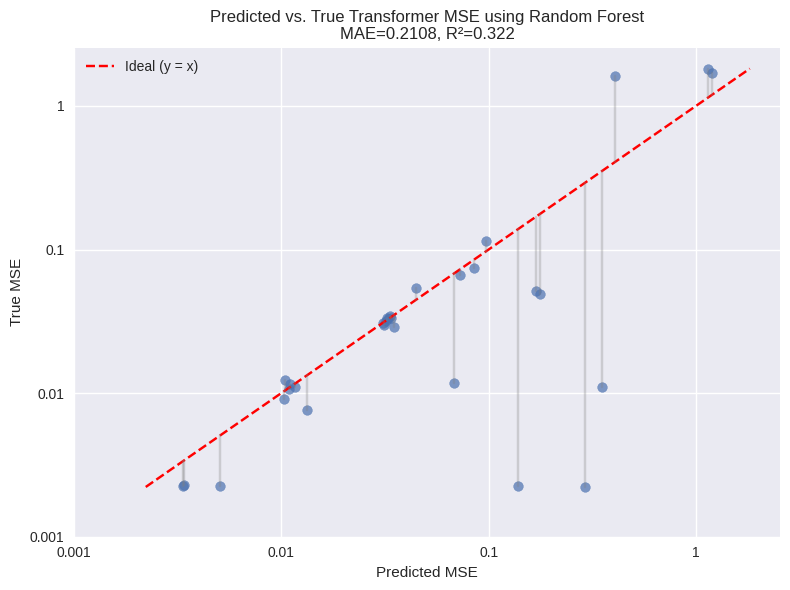

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

X = np.array(features)
y = np.array(targets)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("Surrogate model error metrics (how good the surrogate model is at predicting how accurate Transformer will be")
print(f"MAE : {mae:0.4f}")
print(f"R²  : {r2:0.3f}")

# Predict MSE for all pairs and find the best one
predicted_mse_all = model.predict(X)
best_index = np.argmin(predicted_mse_all)
print("Best predicted pair index:", best_index)
print("Predicted Transformer val MSE:", predicted_mse_all[best_index])
print("True Transformer val MSE:", targets[best_index])

plt.figure(figsize=(8, 6))
plt.scatter(predicted_mse_all, targets, alpha=0.7)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', label='Ideal (y = x)')
# plotting error lines
for i in range(len(targets)):
    plt.plot([predicted_mse_all[i], predicted_mse_all[i]],
             [predicted_mse_all[i], targets[i]],
             'gray', alpha=0.3)
plt.xlabel("Predicted MSE")
plt.ylabel("True MSE")
plt.xscale("log")
plt.yscale("log")
plt.xticks([0.001, 0.01, 0.1, 1], ["0.001", "0.01", "0.1", "1"])
plt.yticks([0.001, 0.01, 0.1, 1], ["0.001", "0.01", "0.1", "1"])
plt.title(f"Predicted vs. True Transformer MSE using Random Forest\nMAE={mae:.4f}, R²={r2:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Best predicted pair index: 16
Predicted Transformer val MSE: 0.011348388716578483
True Transformer val MSE: 0.0022923131


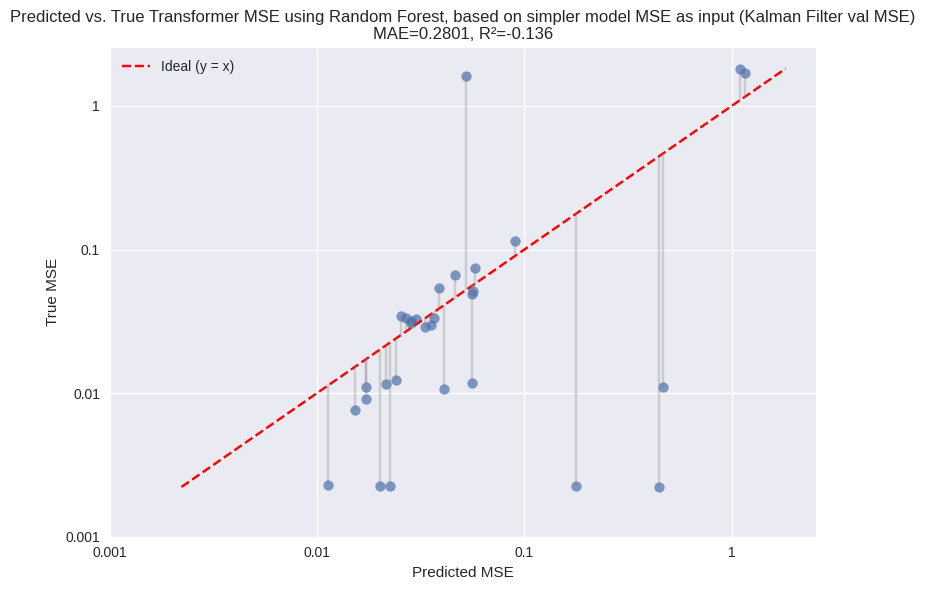

Best predicted pair index: 18
Predicted Transformer val MSE: 0.0030164900422096253
True Transformer val MSE: 0.0022207238


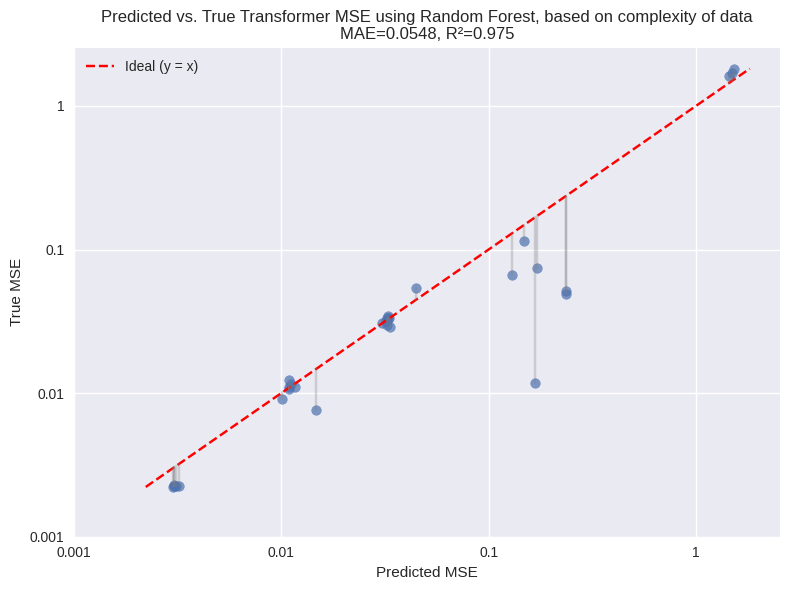

In [ ]:
# for feature in features:
#   print(feature) # each feature is of form [kalman_mse_with_TA, kalman_mse_without_TA, corr_close, acf_lag1, vol_ratio]

features_with_only_mse = [feature[:2] for feature in features] #  [kalman_mse_with_TA, kalman_mse_without_TA] e
features_with_only_timeseries_info = [feature[2:] for feature in features] # [corr_close, acf_lag1, vol_ratio]

### 1. try prediction with only simpler model's MSE ###
X = np.array(features_with_only_mse)
y = np.array(targets)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_with_only_mse = RandomForestRegressor(n_estimators=100, random_state=42)
model_with_only_mse.fit(X_train, y_train)

y_pred = model_with_only_mse.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

# Predict MSE for all pairs and find the best one
predicted_mse_all = model_with_only_mse.predict(X)
best_index = np.argmin(predicted_mse_all)
print("Best predicted pair index:", best_index)
print("Predicted Transformer val MSE:", predicted_mse_all[best_index])
print("True Transformer val MSE:", targets[best_index])

plt.figure(figsize=(8, 6))
plt.scatter(predicted_mse_all, targets, alpha=0.7)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', label='Ideal (y = x)')
# plotting error lines
for i in range(len(targets)):
    plt.plot([predicted_mse_all[i], predicted_mse_all[i]],
             [predicted_mse_all[i], targets[i]],
             'gray', alpha=0.3)
plt.xlabel("Predicted MSE")
plt.ylabel("True MSE")
plt.xscale("log")
plt.yscale("log")
plt.xticks([0.001, 0.01, 0.1, 1], ["0.001", "0.01", "0.1", "1"])
plt.yticks([0.001, 0.01, 0.1, 1], ["0.001", "0.01", "0.1", "1"])
plt.title(f"Predicted vs. True Transformer MSE using Random Forest, based on simpler model MSE as input (Kalman Filter val MSE)\nMAE={mae:.4f}, R²={r2:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. try prediction with only knowledge of the data ###
X = np.array(features_with_only_timeseries_info)
y = np.array(targets)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_with_only_timeseries_info = RandomForestRegressor(n_estimators=100, random_state=42)
model_with_only_timeseries_info.fit(X_train, y_train)

y_pred = model_with_only_timeseries_info.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

# Predict MSE for all pairs and find the best one
predicted_mse_all = model_with_only_timeseries_info.predict(X)
best_index = np.argmin(predicted_mse_all)
print("Best predicted pair index:", best_index)
print("Predicted Transformer val MSE:", predicted_mse_all[best_index])
print("True Transformer val MSE:", targets[best_index])

plt.figure(figsize=(8, 6))
plt.scatter(predicted_mse_all, targets, alpha=0.7)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', label='Ideal (y = x)')
# plotting error lines
for i in range(len(targets)):
    plt.plot([predicted_mse_all[i], predicted_mse_all[i]],
             [predicted_mse_all[i], targets[i]],
             'gray', alpha=0.3)
plt.xlabel("Predicted MSE")
plt.ylabel("True MSE")
plt.xscale("log")
plt.yscale("log")
plt.xticks([0.001, 0.01, 0.1, 1], ["0.001", "0.01", "0.1", "1"])
plt.yticks([0.001, 0.01, 0.1, 1], ["0.001", "0.01", "0.1", "1"])
plt.title(f"Predicted vs. True Transformer MSE using Random Forest, based on complexity of data\nMAE={mae:.4f}, R²={r2:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Now for another time period, does it also hold?

features_2nd_period = []
targets_2nd_period = []

startDateStr_2nd_period, endDateStr_2nd_period = '2010-10-01', '2024-10-02'
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data_2nd_period = gather_data_cached(startDateStr_2nd_period, endDateStr_2nd_period, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1_2nd_period, data_open_filtered_1_2nd_period, data_high_filtered_1_2nd_period, data_low_filtered_1_2nd_period, data_vol_filtered_1_2nd_period, data_original_format_filtered_1_2nd_period = step_1_filter_remove_nans(data_2nd_period['close'], data_2nd_period['open'], data_2nd_period['high'], data_2nd_period['low'], data_2nd_period['vol'], data_2nd_period)
data_close_filtered_2_2nd_period, data_open_filtered_2_2nd_period, data_high_filtered_2_2nd_period, data_low_filtered_2_2nd_period, data_vol_filtered_2_2nd_period, data_original_format_filtered_2_2nd_period = step_2_filter_liquidity(data_close_filtered_1_2nd_period, data_open_filtered_1_2nd_period, data_high_filtered_1_2nd_period, data_low_filtered_1_2nd_period, data_vol_filtered_1_2nd_period, data_original_format_filtered_1_2nd_period)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
pairs_data_filtered_2nd_period = gather_pairs_data_cached(startDateStr_2nd_period, endDateStr_2nd_period, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

for i in tqdm(range(len(pairs_data_filtered_2nd_period[:30]))):
    pair_tup_str = f"{pairs_data_filtered_2nd_period[i][0][0]}_{pairs_data_filtered_2nd_period[i][0][1]}"
    ticker_a, ticker_b = pairs_data_filtered_2nd_period[i][0][0], pairs_data_filtered_2nd_period[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2_2nd_period, data_open_filtered_2_2nd_period, data_high_filtered_2_2nd_period, data_low_filtered_2_2nd_period, data_vol_filtered_2_2nd_period, ticker_a, ticker_b)

    # Get Kalman MSEs
    output_kalman_with_TA = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=True)
    output_kalman_without_TA = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=False)
    kalman_mse_with_TA = output_kalman_with_TA['val_mse']
    kalman_mse_without_TA = output_kalman_without_TA['val_mse']

    # Get Transformer MSE (target)
    output_transformer = execute_transformer_workflow(pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=True, epochs=20)
    transformer_val_mse = output_transformer['test_mse'] # we'll secretly try this with test mse for now, but use val mse later (val MSE seems not to be indicative enough of test MSE currently).

    # add 3 possibly interesting features for a transformer in a single line or 2 like this:
    corr_close  = pairs_timeseries_df['S1_close'].corr(pairs_timeseries_df['S2_close'])
    acf_lag1    = pairs_timeseries_df['S1_close'].pct_change().dropna().autocorr(lag=1)
    vol_ratio   = (pairs_timeseries_df['S1_close'].pct_change().std() / pairs_timeseries_df['S2_close'].pct_change().std())

    # Build feature vector
    features_2nd_period.append([kalman_mse_with_TA, kalman_mse_without_TA, corr_close, acf_lag1, vol_ratio])
    targets_2nd_period.append(transformer_val_mse)

  0%|          | 0/30 [00:00<?, ?it/s]/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Epoch 010 | train MSE 0.001586 | val MSE 0.046547
Epoch 020 | train MSE 0.001323 | val MSE 0.053216
Test MSE  : 34.866562


  3%|▎         | 1/30 [00:18<08:42, 18.01s/it]/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Epoch 010 | train MSE 0.001636 | val MSE 0.016630
Epoch 020 | train MSE 0.001403 | val MSE 0.018414
Test MSE  : 37.516315


  7%|▋         | 2/30 [00:36<08:24, 18.01s/it]

Epoch 010 | train MSE 0.001653 | val MSE 0.024803
Epoch 020 | train MSE 0.001381 | val MSE 0.029030
Test MSE  : 29.881357


 10%|█         | 3/30 [00:54<08:14, 18.31s/it]/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Epoch 010 | train MSE 0.001607 | val MSE 0.032405
Epoch 020 | train MSE 0.001288 | val MSE 0.035398
Test MSE  : 35.561134


 13%|█▎        | 4/30 [01:12<07:53, 18.21s/it]

Epoch 010 | train MSE 0.001451 | val MSE 0.031086
Epoch 020 | train MSE 0.001237 | val MSE 0.028348
Test MSE  : 18.074636


 17%|█▋        | 5/30 [01:30<07:35, 18.22s/it]

Epoch 010 | train MSE 0.001458 | val MSE 0.048677
Epoch 020 | train MSE 0.001274 | val MSE 0.049400
Test MSE  : 16.422377


 20%|██        | 6/30 [01:49<07:15, 18.16s/it]

Epoch 010 | train MSE 0.001553 | val MSE 0.074955
Epoch 020 | train MSE 0.001443 | val MSE 0.077951
Test MSE  : 16.135113


 23%|██▎       | 7/30 [02:07<06:56, 18.11s/it]

Epoch 010 | train MSE 0.001581 | val MSE 0.046213
Epoch 020 | train MSE 0.001332 | val MSE 0.054230
Test MSE  : 20.672426


 27%|██▋       | 8/30 [02:24<06:37, 18.05s/it]/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Epoch 010 | train MSE 0.001635 | val MSE 0.084280
Epoch 020 | train MSE 0.001447 | val MSE 0.083793
Test MSE  : 23.963026


 30%|███       | 9/30 [02:42<06:18, 18.02s/it]/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Epoch 010 | train MSE 0.001557 | val MSE 0.091814
Epoch 020 | train MSE 0.001380 | val MSE 0.105996
Test MSE  : 23.370104


 33%|███▎      | 10/30 [03:00<06:00, 18.00s/it]/content/bsc-thesis/src/models/statistical_models.py:291: RuntimeWarning: invalid value encountered in power
  gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]
/content/bsc-thesis/src/models/statistical_models.py:291: RuntimeWarning: invalid value encountered in power
  gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]


Epoch 010 | train MSE 0.001452 | val MSE 0.057001
Epoch 020 | train MSE 0.001418 | val MSE 0.060749
Test MSE  : 17.443262


/content/bsc-thesis/src/models/transformer_model.py:302: RuntimeWarning: invalid value encountered in scalar power
  gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)
 37%|███▋      | 11/30 [03:19<05:43, 18.10s/it]

Epoch 010 | train MSE 0.001764 | val MSE 0.039348
Epoch 020 | train MSE 0.001337 | val MSE 0.038332
Test MSE  : 28.831030


 40%|████      | 12/30 [03:37<05:24, 18.05s/it]

Epoch 010 | train MSE 0.001476 | val MSE 0.057840
Epoch 020 | train MSE 0.001243 | val MSE 0.054026
Test MSE  : 19.555864


 43%|████▎     | 13/30 [03:54<05:05, 17.99s/it]/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Epoch 010 | train MSE 0.001573 | val MSE 0.045450
Epoch 020 | train MSE 0.001366 | val MSE 0.053197
Test MSE  : 15.880403


 47%|████▋     | 14/30 [04:12<04:47, 17.95s/it]/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Epoch 010 | train MSE 0.001539 | val MSE 0.101489
Epoch 020 | train MSE 0.001537 | val MSE 0.101956
Test MSE  : 25.114321


 50%|█████     | 15/30 [04:30<04:29, 17.94s/it]

Epoch 010 | train MSE 0.004899 | val MSE 0.019652
Epoch 020 | train MSE 0.005187 | val MSE 0.018175
Test MSE  : 0.615188


 53%|█████▎    | 16/30 [04:48<04:11, 17.94s/it]/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Epoch 010 | train MSE 0.001639 | val MSE 0.054758
Epoch 020 | train MSE 0.001459 | val MSE 0.058930
Test MSE  : 21.909994


 57%|█████▋    | 17/30 [05:06<03:53, 17.93s/it]

Epoch 010 | train MSE 0.005747 | val MSE 0.021553
Epoch 020 | train MSE 0.006388 | val MSE 0.016867
Test MSE  : 0.587083


 60%|██████    | 18/30 [05:24<03:35, 17.99s/it]

Epoch 010 | train MSE 0.001652 | val MSE 0.039304
Epoch 020 | train MSE 0.001401 | val MSE 0.055496
Test MSE  : 19.053770


 63%|██████▎   | 19/30 [05:42<03:17, 17.98s/it]/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Epoch 010 | train MSE 0.001597 | val MSE 0.061705
Epoch 020 | train MSE 0.001240 | val MSE 0.044561
Test MSE  : 18.411131


 67%|██████▋   | 20/30 [06:00<03:00, 18.00s/it]

Epoch 010 | train MSE 0.003179 | val MSE 0.032645
Epoch 020 | train MSE 0.002974 | val MSE 0.030155
Test MSE  : 1.025442


 70%|███████   | 21/30 [06:19<02:44, 18.24s/it]

Epoch 010 | train MSE 0.003933 | val MSE 0.017060
Epoch 020 | train MSE 0.003908 | val MSE 0.012414
Test MSE  : 0.901140


 73%|███████▎  | 22/30 [06:37<02:25, 18.19s/it]

Epoch 010 | train MSE 0.003405 | val MSE 0.021688
Epoch 020 | train MSE 0.003044 | val MSE 0.020022
Test MSE  : 3.111782


 77%|███████▋  | 23/30 [06:55<02:07, 18.17s/it]/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Epoch 010 | train MSE 0.001430 | val MSE 0.081186
Epoch 020 | train MSE 0.001390 | val MSE 0.090342
Test MSE  : 32.532574


 80%|████████  | 24/30 [07:13<01:48, 18.06s/it]

Epoch 010 | train MSE 0.003312 | val MSE 0.033798
Epoch 020 | train MSE 0.003295 | val MSE 0.030645
Test MSE  : 3.280298


 83%|████████▎ | 25/30 [07:31<01:30, 18.03s/it]

Epoch 010 | train MSE 0.003027 | val MSE 0.029291
Epoch 020 | train MSE 0.002765 | val MSE 0.026368
Test MSE  : 11.143657


 87%|████████▋ | 26/30 [07:49<01:12, 18.04s/it]

Epoch 010 | train MSE 0.004721 | val MSE 0.018709
Epoch 020 | train MSE 0.004302 | val MSE 0.012256
Test MSE  : 0.795674


 90%|█████████ | 27/30 [08:07<00:54, 18.04s/it]

Epoch 010 | train MSE 0.003249 | val MSE 0.031040
Epoch 020 | train MSE 0.003084 | val MSE 0.027978
Test MSE  : 5.330424


 93%|█████████▎| 28/30 [08:25<00:36, 18.05s/it]/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Epoch 010 | train MSE 0.001473 | val MSE 0.067898
Epoch 020 | train MSE 0.001222 | val MSE 0.058284
Test MSE  : 20.822023


 97%|█████████▋| 29/30 [08:43<00:18, 18.05s/it]

Epoch 010 | train MSE 0.003967 | val MSE 0.022911
Epoch 020 | train MSE 0.003877 | val MSE 0.014229
Test MSE  : 0.611666


100%|██████████| 30/30 [09:01<00:00, 18.06s/it]


NameError: name 'model_with_only_timeseries_info' is not defined

Best predicted pair index: 15
Predicted Transformer val MSE: 0.08005250355228782
True Transformer val MSE: 0.61518824


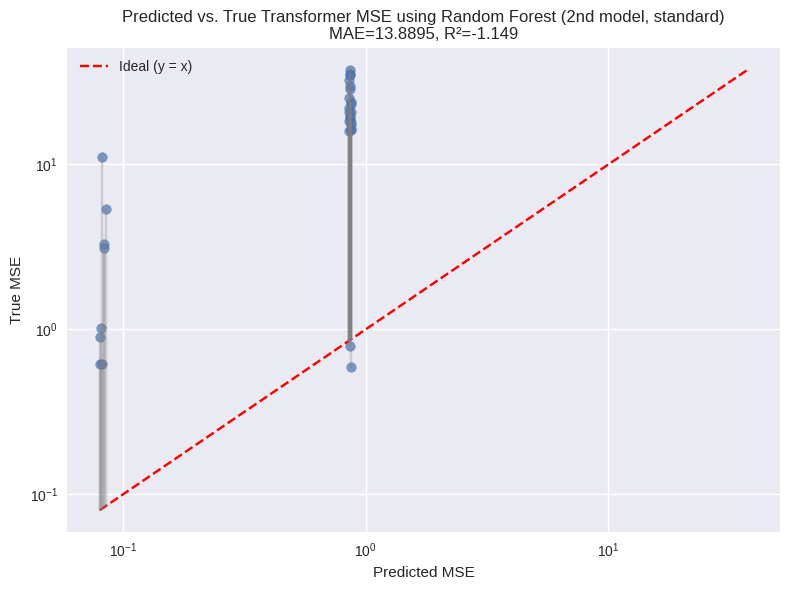

Best predicted pair index: 15
Predicted Transformer val MSE: 0.02525506627280265
True Transformer val MSE: 0.61518824


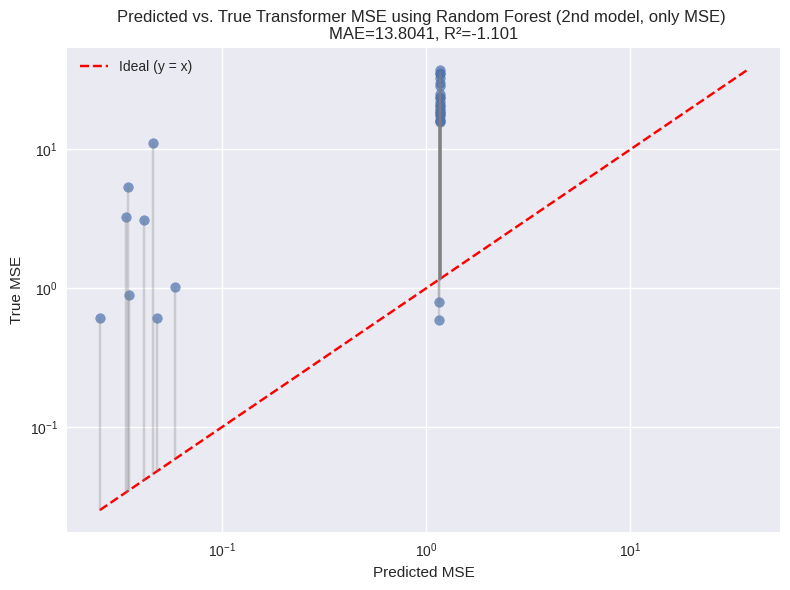

Best predicted pair index: 26
Predicted Transformer val MSE: 0.13934919282793998
True Transformer val MSE: 0.7956743


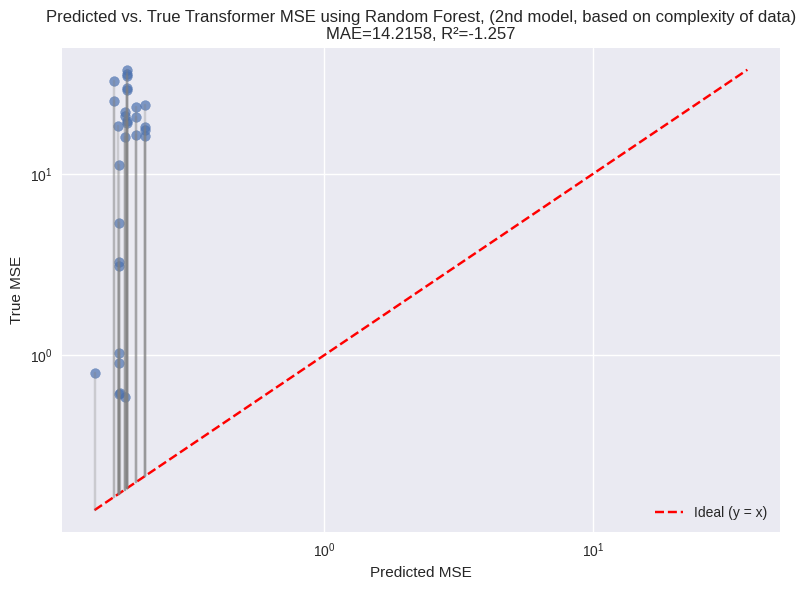

(0.7672963885962963, 37.516315, 0.13934919282793998, 0.21529907997697592)

In [ ]:

features_with_only_mse_2nd_period = [feature[:2] for feature in features_2nd_period] #  [kalman_mse_with_TA, kalman_mse_without_TA] e
features_with_only_timeseries_info_2nd_period = [feature[2:] for feature in features_2nd_period] # [corr_close, acf_lag1, vol_ratio]

# Now, let's see the prediction accuracy using the old models.
### 1. Normal model
X = np.array(features_2nd_period)
y = np.array(targets_2nd_period)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# No training the model this time, just predicting out of the box.
y_pred = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

# Predict MSE for all pairs and find the best one
predicted_mse_all = model.predict(X)
best_index = np.argmin(predicted_mse_all)
print("Best predicted pair index:", best_index)
print("Predicted Transformer val MSE:", predicted_mse_all[best_index])
print("True Transformer val MSE:", targets_2nd_period[best_index])

plt.figure(figsize=(8, 6))
plt.scatter(predicted_mse_all, targets_2nd_period, alpha=0.7)
x_min = min(min(predicted_mse_all), min(targets_2nd_period))
x_max = max(max(predicted_mse_all), max(targets_2nd_period))
plt.plot([x_min, x_max], [x_min, x_max], 'r--', label='Ideal (y = x)')# plotting error lines
for i in range(len(targets_2nd_period)):
    plt.plot([predicted_mse_all[i], predicted_mse_all[i]],
             [predicted_mse_all[i], targets_2nd_period[i]],
             'gray', alpha=0.3)
plt.xlabel("Predicted MSE")
plt.ylabel("True MSE")
plt.xscale("log")
plt.yscale("log")
plt.title(f"Predicted vs. True Transformer MSE using Random Forest (2nd model, standard)\nMAE={mae:.4f}, R²={r2:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
### 2. only MSE model
X = np.array(features_with_only_mse_2nd_period)
y = np.array(targets_2nd_period)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# No training the model this time, just predicting out of the box.
y_pred = model_with_only_mse.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

# Predict MSE for all pairs and find the best one
predicted_mse_all = model_with_only_mse.predict(X)
best_index = np.argmin(predicted_mse_all)
print("Best predicted pair index:", best_index)
print("Predicted Transformer val MSE:", predicted_mse_all[best_index])
print("True Transformer val MSE:", targets_2nd_period[best_index])

plt.figure(figsize=(8, 6))
plt.scatter(predicted_mse_all, targets_2nd_period, alpha=0.7)
x_min = min(min(predicted_mse_all), min(targets_2nd_period))
x_max = max(max(predicted_mse_all), max(targets_2nd_period))
plt.plot([x_min, x_max], [x_min, x_max], 'r--', label='Ideal (y = x)')# plotting error lines
for i in range(len(targets_2nd_period)):
    plt.plot([predicted_mse_all[i], predicted_mse_all[i]],
             [predicted_mse_all[i], targets_2nd_period[i]],
             'gray', alpha=0.3)
plt.xlabel("Predicted MSE")
plt.ylabel("True MSE")
plt.xscale("log")
plt.yscale("log")
plt.title(f"Predicted vs. True Transformer MSE using Random Forest (2nd model, only MSE) \nMAE={mae:.4f}, R²={r2:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### 3. only features model
X = np.array(features_with_only_timeseries_info_2nd_period)
y = np.array(targets_2nd_period)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# No training the model this time, just predicting out of the box.
y_pred = model_with_only_timeseries_info.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

# Predict MSE for all pairs and find the best one
predicted_mse_all = model_with_only_timeseries_info.predict(X)
best_index = np.argmin(predicted_mse_all)
print("Best predicted pair index:", best_index)
print("Predicted Transformer val MSE:", predicted_mse_all[best_index])
print("True Transformer val MSE:", targets_2nd_period[best_index])

plt.figure(figsize=(8, 6))
plt.scatter(predicted_mse_all, targets_2nd_period, alpha=0.7)
x_min = min(min(predicted_mse_all), min(targets_2nd_period))
x_max = max(max(predicted_mse_all), max(targets_2nd_period))
plt.plot([x_min, x_max], [x_min, x_max], 'r--', label='Ideal (y = x)')# plotting error lines
for i in range(len(targets_2nd_period)):
    plt.plot([predicted_mse_all[i], predicted_mse_all[i]],
             [predicted_mse_all[i], targets_2nd_period[i]],
             'gray', alpha=0.3)
plt.xlabel("Predicted MSE")
plt.ylabel("True MSE")
plt.xscale("log")
plt.yscale("log")
plt.title(f"Predicted vs. True Transformer MSE using Random Forest, (2nd model, based on complexity of data)\nMAE={mae:.4f}, R²={r2:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
min(targets_2nd_period + predicted_mse_all), max(targets_2nd_period), min(predicted_mse_all), max(predicted_mse_all)

In [ ]:

# TOMORROW:
# 1. Take a single pair of data, and plot the train, val, test MSE for different epochs.